# Simple Moving Average Strategy (SMA=20)

1. When the close price becomes higher than the 20-day SMA, buy one share
2. When the close price becomes lower than the 20-day SMA and we have a share, sell it.
3. We can only have a maximum of one share at any given time.
4. No short selling is allowed.

In [1]:
import matplotlib as plt
%matplotlib inline
from datetime import datetime
import backtrader as bt
import yfinance as yf
%matplotlib inline

### Signal

In [2]:
class SmaSignal(bt.Signal):
    params = (('period', 20), )
    
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

In [3]:
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2018-12-31'))


[*********************100%***********************]  1 of 1 completed


In [4]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [5]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Starting Portfolio Value: 1002.61


In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)

### Strategy

In [132]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return
        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

In [133]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [134]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2018-02-14, BUY CREATED --- Price: 41.84
2018-02-15, BUY EXECUTED --- Price: 42.45, Cost: 42.45, Commission: 0.00
2018-03-19, SELL CREATED --- Price: 43.83
2018-03-20, SELL EXECUTED --- Price: 43.81, Cost: 42.45, Commission: 0.00
2018-03-20, OPERATION RESULT --- Gross: 1.36, Net: 1.36
2018-04-10, BUY CREATED --- Price: 43.31
2018-04-11, BUY EXECUTED --- Price: 43.06, Cost: 43.06, Commission: 0.00
2018-04-20, SELL CREATED --- Price: 41.43
2018-04-23, SELL EXECUTED --- Price: 41.71, Cost: 43.06, Commission: 0.00
2018-04-23, OPERATION RESULT --- Gross: -1.35, Net: -1.35
2018-05-02, BUY CREATED --- Price: 44.14
2018-05-03, BUY EXECUTED --- Price: 43.97, Cost: 43.97, Commission: 0.00
2018-06-15, SELL CREATED --- Price: 47.21
2018-06-18, SELL EXECUTED --- Price: 46.97, Cost: 43.97, Commission: 0.00
2018-06-18, OPERATION RESULT --- Gross: 3.00, Net: 3.00
2018-07-06, BUY CREATED --- Price: 46.99
2018-07-09, BUY EXECUTED --- Price: 47.38, Cost: 47.38, Commissio

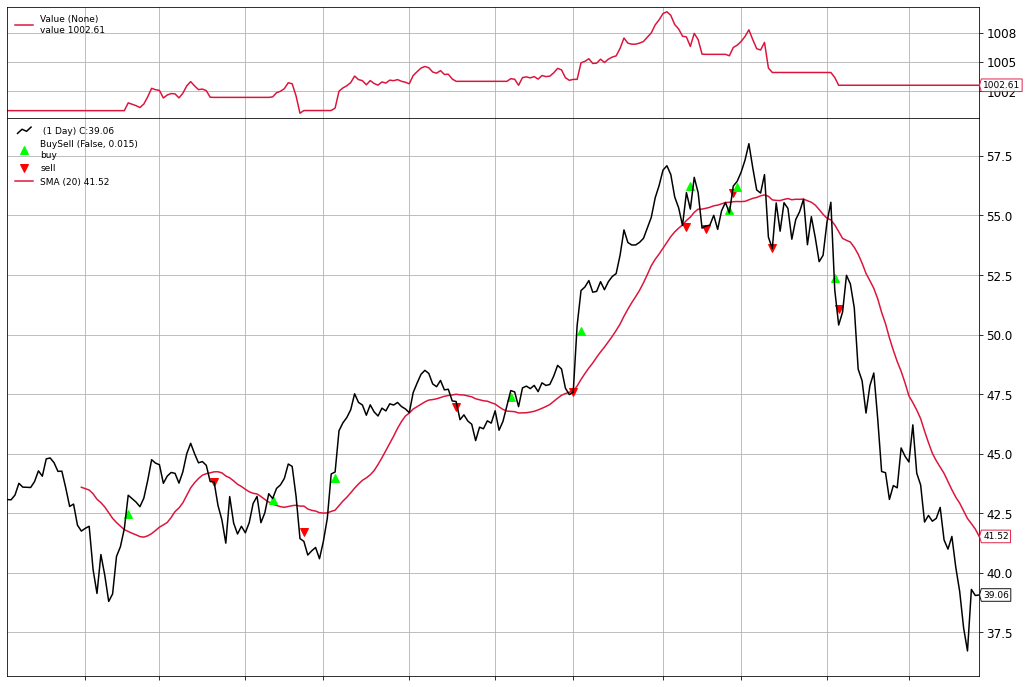

[[<Figure size 1080x720 with 2 Axes>]]

In [135]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)

### Strategy Optimization

In [ ]:
# Create a Stratey
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders
        self.order = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        # set no pending order
        self.order = None

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.order = self.sell()

    def stop(self):
        self.log(f'(ma_period = {self.params.ma_period:2d}) --- Terminal Value: {self.broker.getvalue():.2f}')

# download data
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2018-12-31'))


# create a Cerebro entity
cerebro = bt.Cerebro(stdstats = False)

# set up the backtest
cerebro.adddata(data)
cerebro.optstrategy(SmaStrategy, ma_period=range(10, 31))
cerebro.broker.setcash(1000.0)
cerebro.run(maxcpus=4)